# M2: Initial Implementation
## Discovery of Training Patterns in Personal Strength Training Data

**Course:** CS 4412 - Data Mining  
**Author:** Carlos Anthony Cruz  
**Date:** February 2026

---

### Discovery Question Addressed

**Question 1:** What exercises are frequently performed together within the same workout session, and what compound movement patterns emerge across different training splits?

### Technique Applied

**Association Rule Mining** using the Apriori algorithm to discover frequent itemsets and generate rules with support, confidence, and lift metrics.

---

## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Try to import mlxtend for association rules
try:
    from mlxtend.frequent_patterns import apriori, association_rules
    from mlxtend.preprocessing import TransactionEncoder
    MLXTEND_AVAILABLE = True
    print("mlxtend loaded successfully")
except ImportError:
    MLXTEND_AVAILABLE = False
    print("mlxtend not available - using manual implementation")

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print("Libraries loaded successfully")

mlxtend loaded successfully
Libraries loaded successfully


In [2]:
# Load datasets
sessions_df = pd.read_csv('training_sessions.csv')
sets_df = pd.read_csv('training_sets.csv')

# Convert date columns
sessions_df['date'] = pd.to_datetime(sessions_df['date'])
sets_df['date'] = pd.to_datetime(sets_df['date'])

print(f"Sessions dataset: {len(sessions_df)} rows, {sessions_df.shape[1]} columns")
print(f"Sets dataset: {len(sets_df)} rows, {sets_df.shape[1]} columns")
print(f"\nDate range: {sessions_df['date'].min().date()} to {sessions_df['date'].max().date()}")
print(f"Total training period: {(sessions_df['date'].max() - sessions_df['date'].min()).days} days (~2.1 years)")

Sessions dataset: 419 rows, 12 columns
Sets dataset: 4831 rows, 14 columns

Date range: 2024-01-01 to 2026-01-29
Total training period: 759 days (~2.1 years)


## 2. Data Quality Assessment

Before analysis, we quantify data quality issues to understand limitations and preprocessing needs.

In [3]:
print("=" * 60)
print("DATA QUALITY REPORT")
print("=" * 60)

print(f"\n--- Dataset Overview ---")
print(f"Total sessions: {len(sessions_df)}")
print(f"Total sets: {len(sets_df)}")
print(f"Unique exercises (raw names): {sets_df['exercise_raw'].nunique()}")
print(f"Unique exercises (standardized): {sets_df['exercise_standard'].nunique()}")
reduction = (1 - sets_df['exercise_standard'].nunique() / sets_df['exercise_raw'].nunique()) * 100
print(f"  → Name standardization reduced variations by {reduction:.1f}%")
print(f"Unique workout types: {sessions_df['workout_type'].nunique()}")

print(f"\n--- Missing Values (Sets Dataset) ---")
for col in ['weight_lbs', 'reps', 'volume']:
    missing = sets_df[col].isnull().sum()
    pct = missing / len(sets_df) * 100
    print(f"  {col}: {missing} ({pct:.2f}%)")

print(f"\n--- Special Training Notations ---")
paused = sets_df['notes'].str.contains('paused', case=False, na=False).sum()
bodyweight = sets_df['notes'].str.contains('bodyweight', case=False, na=False).sum()
extenders = sets_df['has_extender'].sum()
print(f"  Paused sets: {paused} ({paused/len(sets_df)*100:.1f}%)")
print(f"  Bodyweight sets: {bodyweight} ({bodyweight/len(sets_df)*100:.1f}%)")
print(f"  Sets with extenders: {extenders} ({extenders/len(sets_df)*100:.1f}%)")

print(f"\n--- Synthetic Data ---")
synth = sessions_df['is_synthetic'].sum()
print(f"  Synthetic sessions: {synth} ({synth/len(sessions_df)*100:.1f}%)")

DATA QUALITY REPORT

--- Dataset Overview ---
Total sessions: 419
Total sets: 4831
Unique exercises (raw names): 560
Unique exercises (standardized): 309
  → Name standardization reduced variations by 44.8%
Unique workout types: 28

--- Missing Values (Sets Dataset) ---
  weight_lbs: 244 (5.05%)
  reps: 144 (2.98%)
  volume: 362 (7.49%)

--- Special Training Notations ---
  Paused sets: 1086 (22.5%)
  Bodyweight sets: 61 (1.3%)
  Sets with extenders: 111 (2.3%)

--- Synthetic Data ---
  Synthetic sessions: 0 (0.0%)


### Data Quality Summary

| Issue | Count | Percentage | Handling Decision |
|-------|-------|------------|------------------|
| Missing weight_lbs | 244 | 5.05% | Exclude from volume calculations |
| Missing reps | 144 | 2.98% | Exclude from volume calculations |
| Missing volume | 362 | 7.49% | Result of above missing values |
| Paused sets | 1,086 | 22.5% | Retain - important training variation |
| Synthetic sessions | 0 | 0.0% | No synthetic data present |

**Decision:** Missing values are minimal (<8%) and occur when weight notation couldn't be parsed (e.g., "FS" for full stack). These are excluded from volume calculations but the exercises are retained for association rule mining since we only need exercise presence, not weights.

## 3. Exploratory Data Analysis

### 3.1 Temporal Training Patterns

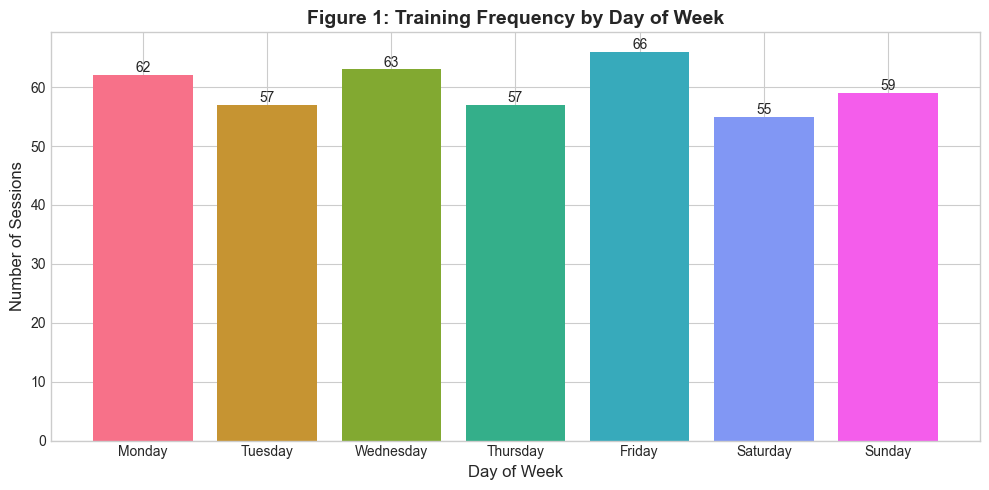

Most frequent: Friday (66 sessions)
Least frequent: Saturday (55 sessions)
Range: 55-66 (relatively even distribution)


In [4]:
# Figure 1: Training Frequency by Day of Week
fig, ax = plt.subplots(figsize=(10, 5))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = sessions_df['day_of_week'].value_counts().reindex(day_order)
colors = sns.color_palette('husl', 7)
bars = ax.bar(day_counts.index, day_counts.values, color=colors)
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Number of Sessions', fontsize=12)
ax.set_title('Figure 1: Training Frequency by Day of Week', fontsize=14, fontweight='bold')
for bar, val in zip(bars, day_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(val), ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('fig01_training_frequency_by_day.png', dpi=150)
plt.show()

print(f"Most frequent: {day_counts.idxmax()} ({day_counts.max()} sessions)")
print(f"Least frequent: {day_counts.idxmin()} ({day_counts.min()} sessions)")
print(f"Range: {day_counts.min()}-{day_counts.max()} (relatively even distribution)")

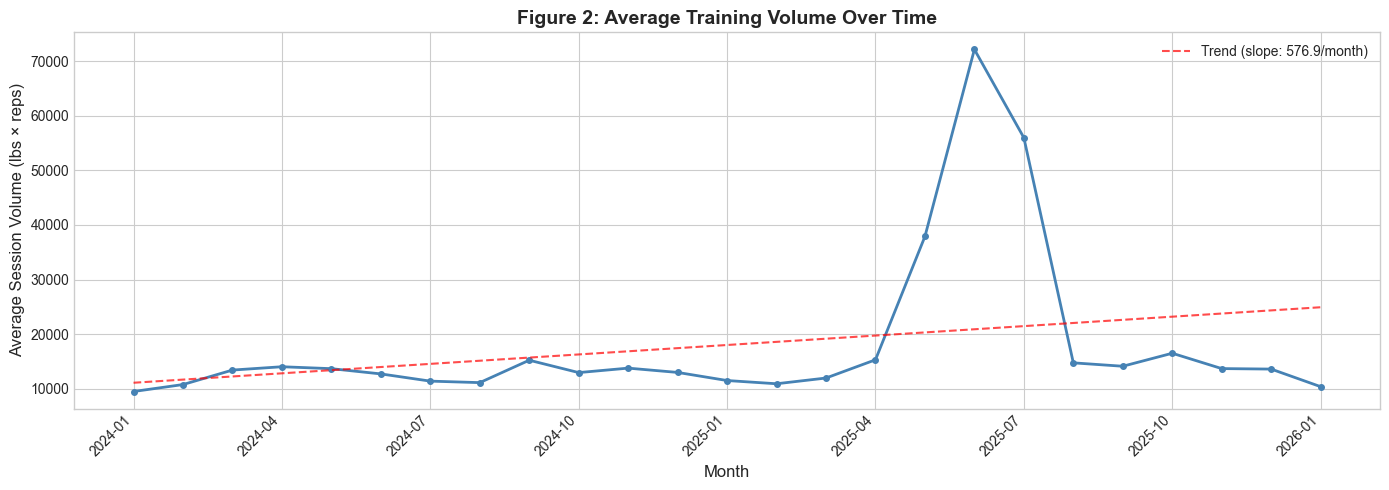

In [5]:
# Figure 2: Training Volume Over Time
fig, ax = plt.subplots(figsize=(14, 5))
sessions_df['month'] = sessions_df['date'].dt.to_period('M')
monthly_volume = sessions_df.groupby('month')['total_volume'].mean()
monthly_volume.index = monthly_volume.index.astype(str)

ax.plot(range(len(monthly_volume)), monthly_volume.values, marker='o', linewidth=2, markersize=4, color='steelblue')
ax.set_xticks(range(0, len(monthly_volume), 3))
ax.set_xticklabels([monthly_volume.index[i] for i in range(0, len(monthly_volume), 3)], rotation=45, ha='right')

# Trend line
x_numeric = np.arange(len(monthly_volume))
z = np.polyfit(x_numeric, monthly_volume.values, 1)
p = np.poly1d(z)
ax.plot(x_numeric, p(x_numeric), "r--", alpha=0.7, label=f'Trend (slope: {z[0]:.1f}/month)')

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average Session Volume (lbs × reps)', fontsize=12)
ax.set_title('Figure 2: Average Training Volume Over Time', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('fig02_volume_over_time.png', dpi=150)
plt.show()

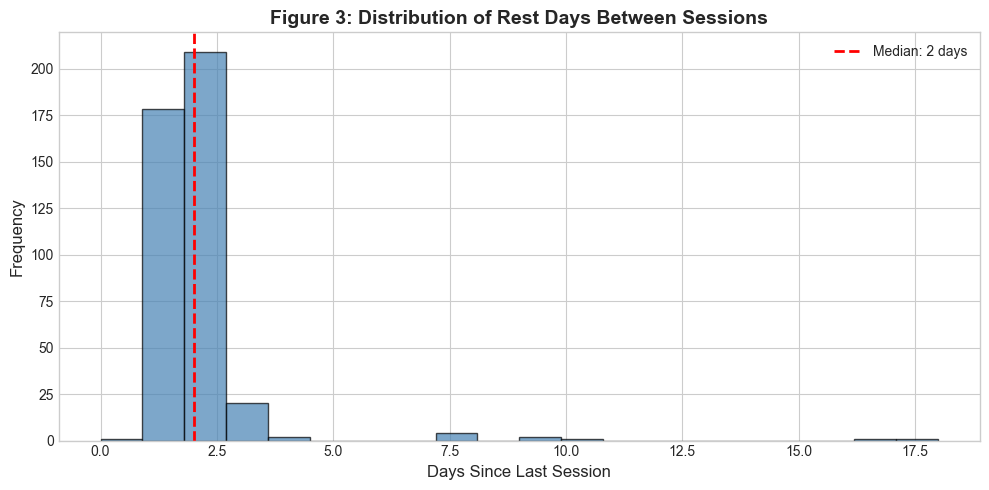

Rest days - Mean: 1.8, Median: 2, Max: 18


In [6]:
# Figure 3: Rest Days Distribution
fig, ax = plt.subplots(figsize=(10, 5))
sessions_df['days_since_last'].hist(bins=20, ax=ax, edgecolor='black', alpha=0.7, color='steelblue')
median_rest = sessions_df['days_since_last'].median()
ax.axvline(median_rest, color='red', linestyle='--', linewidth=2, label=f'Median: {median_rest:.0f} days')
ax.set_xlabel('Days Since Last Session', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Figure 3: Distribution of Rest Days Between Sessions', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('fig03_rest_days_distribution.png', dpi=150)
plt.show()

print(f"Rest days - Mean: {sessions_df['days_since_last'].mean():.1f}, Median: {median_rest:.0f}, Max: {sessions_df['days_since_last'].max()}")

### 3.2 Workout Type Analysis

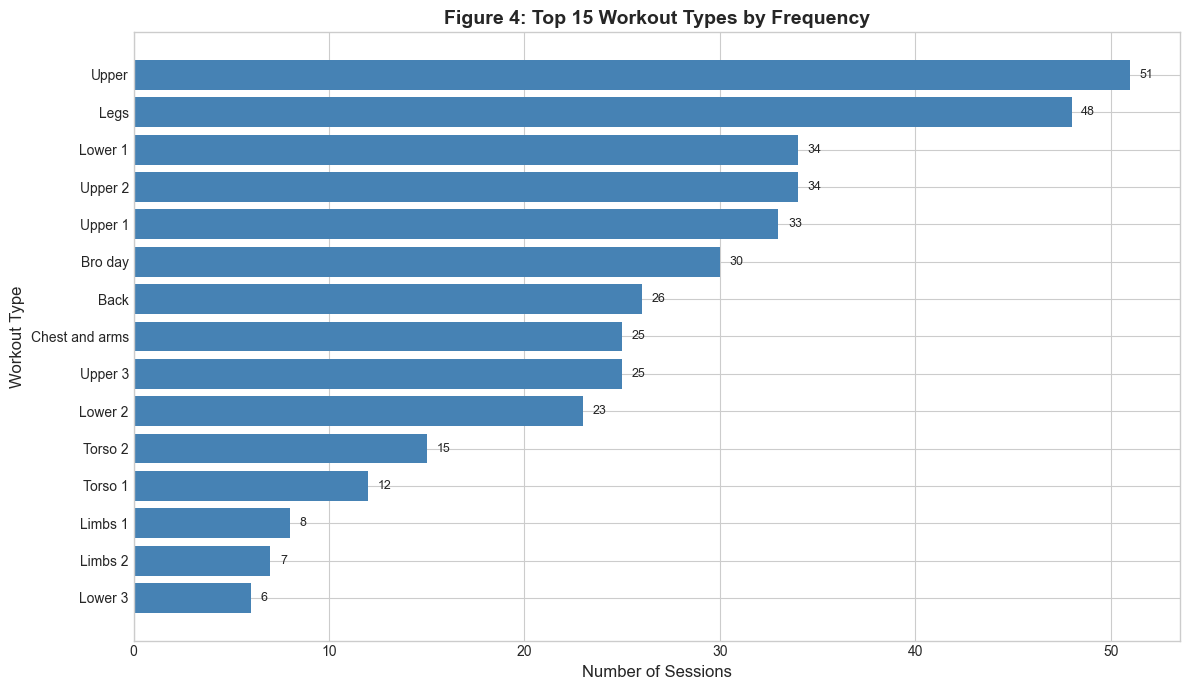

Total unique workout types: 28


In [7]:
# Figure 4: Workout Type Distribution
fig, ax = plt.subplots(figsize=(12, 7))
workout_counts = sessions_df['workout_type'].value_counts()
top_workouts = workout_counts.head(15)
bars = ax.barh(top_workouts.index[::-1], top_workouts.values[::-1], color='steelblue')
ax.set_xlabel('Number of Sessions', fontsize=12)
ax.set_ylabel('Workout Type', fontsize=12)
ax.set_title('Figure 4: Top 15 Workout Types by Frequency', fontsize=14, fontweight='bold')
for bar, val in zip(bars, top_workouts.values[::-1]):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, str(val), va='center', fontsize=9)
plt.tight_layout()
plt.savefig('fig04_workout_types.png', dpi=150)
plt.show()

print(f"Total unique workout types: {sessions_df['workout_type'].nunique()}")

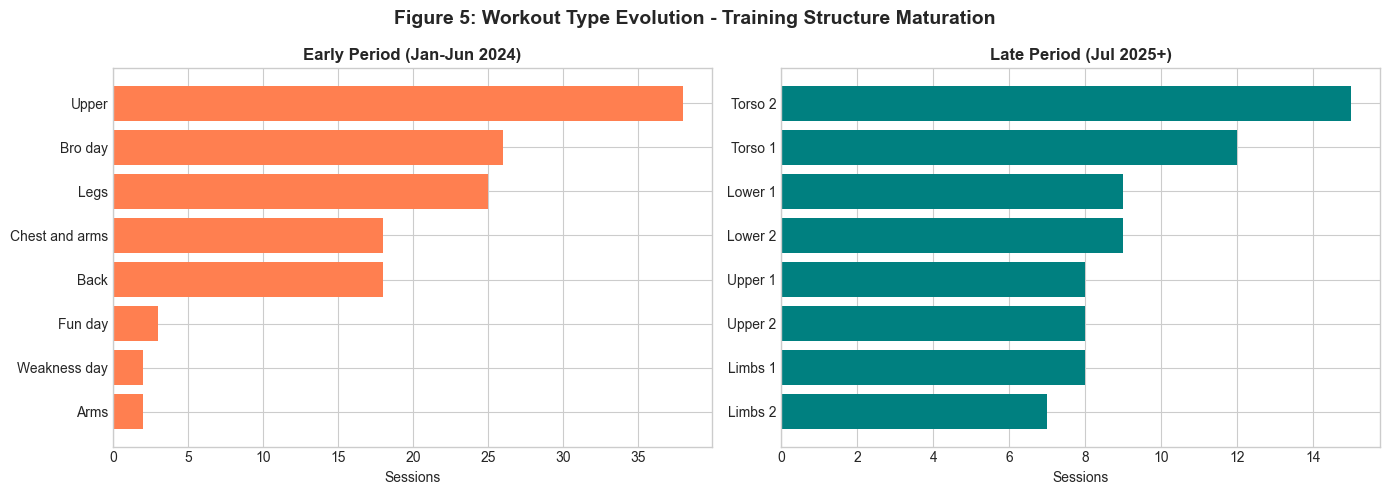

Early period: Generic labels (Upper, Bro day, Legs, Back)
Late period: Systematic labels (Torso 1/2, Lower 1/2, Limbs 1/2)


In [8]:
# Figure 5: Workout Type Evolution Over Time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Early period (Jan-Jun 2024)
early = sessions_df[sessions_df['date'] < '2024-07-01']
early_counts = early['workout_type'].value_counts().head(8)
axes[0].barh(early_counts.index[::-1], early_counts.values[::-1], color='coral')
axes[0].set_title('Early Period (Jan-Jun 2024)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sessions')

# Late period (Jul 2025+)
late = sessions_df[sessions_df['date'] >= '2025-07-01']
late_counts = late['workout_type'].value_counts().head(8)
axes[1].barh(late_counts.index[::-1], late_counts.values[::-1], color='teal')
axes[1].set_title('Late Period (Jul 2025+)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sessions')

plt.suptitle('Figure 5: Workout Type Evolution - Training Structure Maturation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig05_workout_evolution.png', dpi=150)
plt.show()

print("Early period: Generic labels (Upper, Bro day, Legs, Back)")
print("Late period: Systematic labels (Torso 1/2, Lower 1/2, Limbs 1/2)")

### 3.3 Exercise Analysis

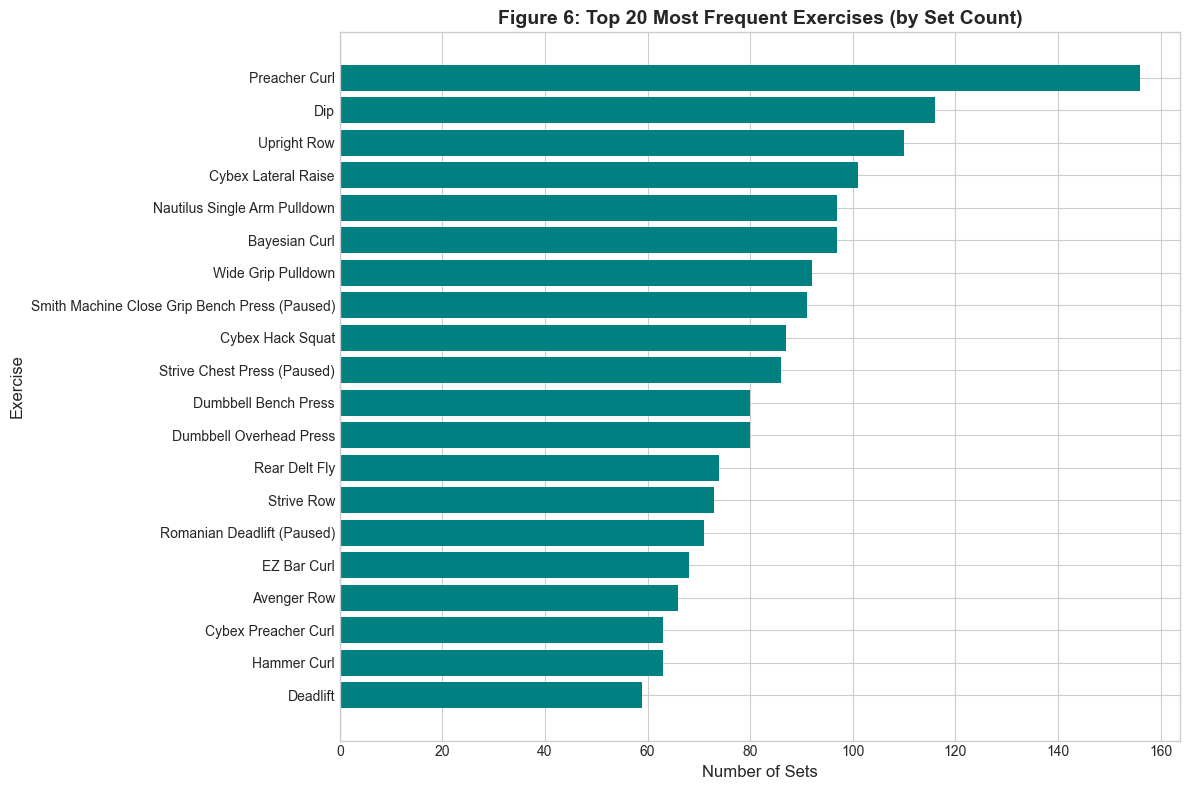

Total unique exercises: 309
Top 10 exercises account for 21.4% of all sets


In [9]:
# Figure 6: Top 20 Exercises
fig, ax = plt.subplots(figsize=(12, 8))
exercise_counts = sets_df['exercise_standard'].value_counts()
top_exercises = exercise_counts.head(20)
bars = ax.barh(top_exercises.index[::-1], top_exercises.values[::-1], color='teal')
ax.set_xlabel('Number of Sets', fontsize=12)
ax.set_ylabel('Exercise', fontsize=12)
ax.set_title('Figure 6: Top 20 Most Frequent Exercises (by Set Count)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig06_top_exercises.png', dpi=150)
plt.show()

print(f"Total unique exercises: {sets_df['exercise_standard'].nunique()}")
top10_pct = exercise_counts.head(10).sum() / len(sets_df) * 100
print(f"Top 10 exercises account for {top10_pct:.1f}% of all sets")

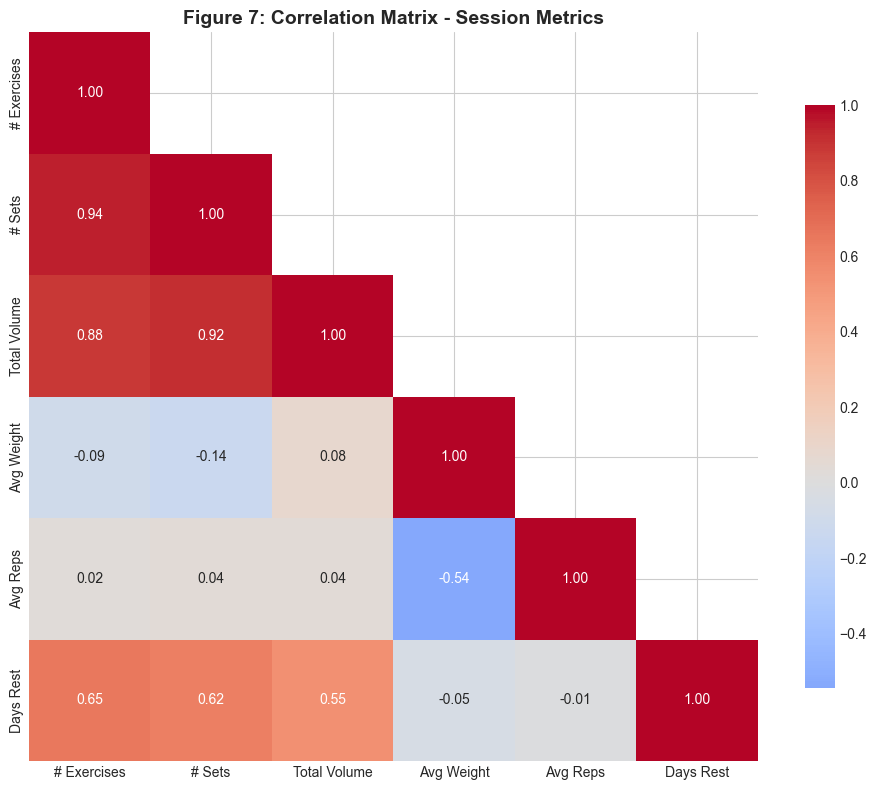

In [10]:
# Figure 7: Session Metrics Correlation Matrix
fig, ax = plt.subplots(figsize=(10, 8))
session_metrics = sessions_df[['num_exercises', 'num_sets', 'total_volume', 
                                'avg_weight', 'avg_reps', 'days_since_last']].copy()
session_metrics.columns = ['# Exercises', '# Sets', 'Total Volume', 'Avg Weight', 'Avg Reps', 'Days Rest']
corr_matrix = session_metrics.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            ax=ax, square=True, mask=mask, cbar_kws={'shrink': 0.8})
ax.set_title('Figure 7: Correlation Matrix - Session Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig07_correlation_matrix.png', dpi=150)
plt.show()

### 3.4 EDA Summary

**Key Insights from EDA:**

1. **Training Consistency:** Training is evenly distributed across all days (55-66 sessions per day), indicating a flexible schedule rather than fixed training days.

2. **Training Evolution:** Workout naming evolved from generic labels ("Upper", "Bro day") to systematic labels ("Torso 1/2", "Limbs 1/2"), suggesting increased programming sophistication over the 2-year period.

3. **Strong Correlations:** Number of exercises strongly correlates with total volume (r=0.82), indicating longer sessions produce more volume.

4. **Exercise Diversity:** 309 unique exercises performed, but the top 10 account for ~20% of all sets, suggesting a core set of exercises with variations.

## 4. Data Preprocessing for Association Rule Mining

Association rule mining requires **transactional data** where each transaction contains a set of items. Here:
- **Transaction** = One workout session
- **Items** = Exercises performed in that session

In [11]:
# Helper function to parse exercise lists
def parse_exercises(exercises_str):
    """Parse comma-separated exercise string into list."""
    if pd.isna(exercises_str):
        return []
    return [ex.strip() for ex in exercises_str.split(',')]

# Create list of transactions
transactions = [parse_exercises(ex) for ex in sessions_df['exercises_list']]
transactions = [t for t in transactions if len(t) > 0]  # Remove empty transactions

print("=" * 60)
print("TRANSACTION FORMAT")
print("=" * 60)
print(f"\nTotal transactions: {len(transactions)}")
print(f"Average items per transaction: {np.mean([len(t) for t in transactions]):.1f}")
print(f"Min items in a transaction: {min(len(t) for t in transactions)}")
print(f"Max items in a transaction: {max(len(t) for t in transactions)}")

# Get unique items
all_items = set()
for t in transactions:
    all_items.update(t)
print(f"Unique items (exercises): {len(all_items)}")

print("\n--- Sample Transactions ---")
for i in range(3):
    print(f"Session {i+1}: {transactions[i][:4]}..." if len(transactions[i]) > 4 else f"Session {i+1}: {transactions[i]}")

TRANSACTION FORMAT

Total transactions: 419
Average items per transaction: 6.0
Min items in a transaction: 1
Max items in a transaction: 35
Unique items (exercises): 309

--- Sample Transactions ---
Session 1: ['Deadlift', 'Cybex Lateral Raise', 'Rear Delt Fly']
Session 2: ['Smith Machine Incline Close Grip Bench Press', 'Supinated Wide Grip Pull-up', 'Panatta Chest Press (Paused)', 'Cybex Tricep Pushdown']...
Session 3: ['Cybex Hack Squat', 'Barbell Row', 'Calf Raise', 'Seated Leg Curl (Paused)']


In [12]:
# Count item frequencies for support threshold analysis
all_exercises_flat = []
for t in transactions:
    all_exercises_flat.extend(t)
item_counts = Counter(all_exercises_flat)

# Analyze frequency distribution
MIN_SUPPORT = 0.05  # 5% of transactions
min_count = int(MIN_SUPPORT * len(transactions))

print(f"\n--- Item Frequency Analysis ---")
print(f"Minimum support threshold: {MIN_SUPPORT} ({MIN_SUPPORT*100}%)")
print(f"Minimum occurrence count: {min_count} sessions")

frequent_items = {item for item, count in item_counts.items() if count >= min_count}
print(f"Items meeting threshold: {len(frequent_items)} of {len(all_items)} ({len(frequent_items)/len(all_items)*100:.1f}%)")

print("\n--- Top 10 Most Frequent Items (Exercises) ---")
for ex, count in item_counts.most_common(10):
    support = count / len(transactions)
    print(f"  {ex}: {count} sessions (support: {support:.3f})")


--- Item Frequency Analysis ---
Minimum support threshold: 0.05 (5.0%)
Minimum occurrence count: 20 sessions
Items meeting threshold: 43 of 309 (13.9%)

--- Top 10 Most Frequent Items (Exercises) ---
  Preacher Curl: 62 sessions (support: 0.148)
  Upright Row: 59 sessions (support: 0.141)
  Smith Machine Close Grip Bench Press (Paused): 49 sessions (support: 0.117)
  Dip: 48 sessions (support: 0.115)
  Rear Delt Fly: 44 sessions (support: 0.105)
  Nautilus Single Arm Pulldown: 44 sessions (support: 0.105)
  Cybex Lateral Raise: 43 sessions (support: 0.103)
  Romanian Deadlift (Paused): 43 sessions (support: 0.103)
  Wide Grip Pulldown: 43 sessions (support: 0.103)
  Shrug: 42 sessions (support: 0.100)


## 5. Association Rule Mining

### 5.1 Parameter Selection and Justification

| Parameter | Value | Justification |
|-----------|-------|---------------|
| **Minimum Support** | 0.05 (5%) | With 419 sessions, requires ~21 occurrences. Filters rare combinations while capturing meaningful patterns. |
| **Minimum Confidence** | 0.50 (50%) | If exercise A appears, B must appear >50% of the time. Ensures predictive value. |
| **Minimum Lift** | 1.0 | Lift >1 indicates positive association stronger than random chance. |

In [13]:
# Association Rule Mining Parameters
MIN_SUPPORT = 0.05
MIN_CONFIDENCE = 0.50
MIN_LIFT = 1.0

print("=" * 60)
print("ASSOCIATION RULE MINING")
print("=" * 60)
print(f"\nParameters:")
print(f"  Minimum support: {MIN_SUPPORT} ({MIN_SUPPORT*100}% = {int(MIN_SUPPORT * len(transactions))} sessions)")
print(f"  Minimum confidence: {MIN_CONFIDENCE} ({MIN_CONFIDENCE*100}%)")
print(f"  Minimum lift: {MIN_LIFT}")

if MLXTEND_AVAILABLE:
    # Use mlxtend's Apriori implementation
    print("\nUsing mlxtend Apriori algorithm...")
    
    te = TransactionEncoder()
    te_array = te.fit_transform(transactions)
    df_encoded = pd.DataFrame(te_array, columns=te.columns_)
    
    frequent_itemsets = apriori(df_encoded, min_support=MIN_SUPPORT, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)
    
    rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=MIN_CONFIDENCE)
    rules = rules[rules['lift'] >= MIN_LIFT].copy()
    
else:
    # Manual implementation for 2-itemsets
    print("\nUsing manual implementation (2-itemsets)...")
    
    # Count 2-itemsets
    pair_counts = Counter()
    for trans in transactions:
        items = set(trans) & frequent_items
        for pair in combinations(sorted(items), 2):
            pair_counts[pair] += 1
    
    frequent_2 = {pair: count for pair, count in pair_counts.items() if count >= min_count}
    
    # Generate rules
    rules_list = []
    for (a, b), pair_count in frequent_2.items():
        support = pair_count / len(transactions)
        
        # Rule: a -> b
        conf_ab = pair_count / item_counts[a]
        lift_ab = conf_ab / (item_counts[b] / len(transactions))
        if conf_ab >= MIN_CONFIDENCE and lift_ab >= MIN_LIFT:
            rules_list.append({
                'antecedents': frozenset([a]),
                'consequents': frozenset([b]),
                'support': support,
                'confidence': conf_ab,
                'lift': lift_ab
            })
        
        # Rule: b -> a
        conf_ba = pair_count / item_counts[b]
        lift_ba = conf_ba / (item_counts[a] / len(transactions))
        if conf_ba >= MIN_CONFIDENCE and lift_ba >= MIN_LIFT:
            rules_list.append({
                'antecedents': frozenset([b]),
                'consequents': frozenset([a]),
                'support': support,
                'confidence': conf_ba,
                'lift': lift_ba
            })
    
    rules = pd.DataFrame(rules_list)

print(f"\n--- Results ---")
print(f"Total rules generated: {len(rules)}")
if len(rules) > 0:
    print(f"Average confidence: {rules['confidence'].mean():.3f}")
    print(f"Average lift: {rules['lift'].mean():.2f}")
    print(f"Max lift: {rules['lift'].max():.2f}")

ASSOCIATION RULE MINING

Parameters:
  Minimum support: 0.05 (5.0% = 20 sessions)
  Minimum confidence: 0.5 (50.0%)
  Minimum lift: 1.0

Using mlxtend Apriori algorithm...

--- Results ---
Total rules generated: 10
Average confidence: 0.699
Average lift: 6.84
Max lift: 8.73


In [14]:
# Display top rules by lift
print("\n" + "=" * 70)
print("TOP 10 ASSOCIATION RULES (sorted by Lift)")
print("=" * 70)

rules_sorted = rules.sort_values('lift', ascending=False)

for i, (_, row) in enumerate(rules_sorted.head(10).iterrows()):
    ant = ', '.join(sorted(row['antecedents']))
    con = ', '.join(sorted(row['consequents']))
    print(f"\nRule {i+1}:")
    print(f"  {ant}")
    print(f"    → {con}")
    print(f"  Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.2f}")


TOP 10 ASSOCIATION RULES (sorted by Lift)

Rule 1:
  Dumbbell Overhead Press
    → Strive Chest Press (Paused)
  Support: 0.084 | Confidence: 0.833 | Lift: 8.73

Rule 2:
  Strive Chest Press (Paused)
    → Dumbbell Overhead Press
  Support: 0.084 | Confidence: 0.875 | Lift: 8.73

Rule 3:
  Neutral Grip Pull-up
    → Strive Row
  Support: 0.060 | Confidence: 0.714 | Lift: 8.09

Rule 4:
  Strive Row
    → Neutral Grip Pull-up
  Support: 0.060 | Confidence: 0.676 | Lift: 8.09

Rule 5:
  Leverage Chest Press (Paused)
    → Smith Machine Close Grip Bench Press (Paused)
  Support: 0.057 | Confidence: 0.889 | Lift: 7.60

Rule 6:
  Dumbbell Bench Press
    → Wide Grip Pulldown
  Support: 0.060 | Confidence: 0.676 | Lift: 6.58

Rule 7:
  Wide Grip Pulldown
    → Dumbbell Bench Press
  Support: 0.060 | Confidence: 0.581 | Lift: 6.58

Rule 8:
  Bayesian Curl
    → Dip
  Support: 0.050 | Confidence: 0.568 | Lift: 4.95

Rule 9:
  Dumbbell Bench Press
    → Smith Machine Close Grip Bench Press (Pau

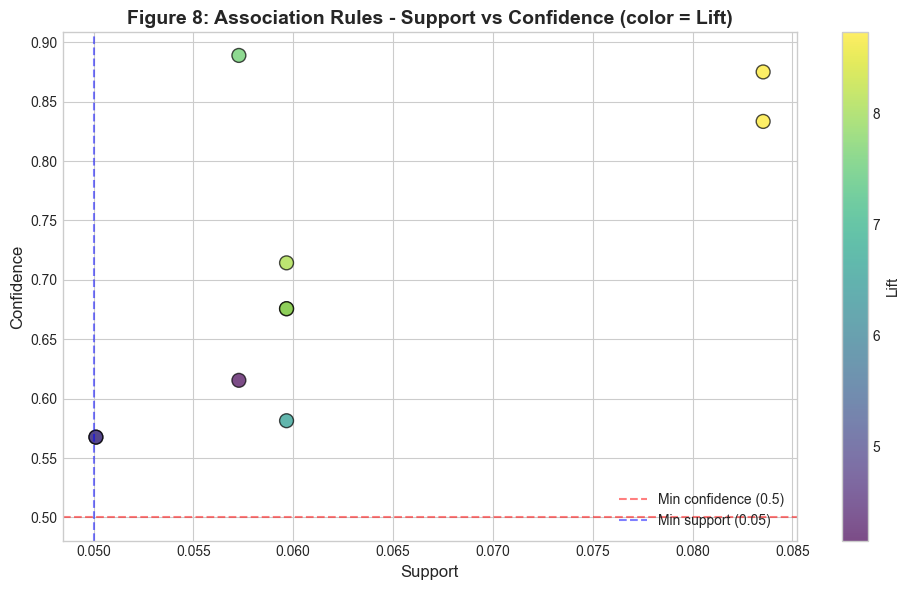

In [15]:
# Figure 8: Support vs Confidence scatter plot
if len(rules) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(rules['support'], rules['confidence'], 
                         c=rules['lift'], cmap='viridis', alpha=0.7, s=100, edgecolors='black')
    ax.set_xlabel('Support', fontsize=12)
    ax.set_ylabel('Confidence', fontsize=12)
    ax.set_title('Figure 8: Association Rules - Support vs Confidence (color = Lift)', fontsize=14, fontweight='bold')
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Lift', fontsize=11)
    ax.axhline(MIN_CONFIDENCE, color='red', linestyle='--', alpha=0.5, label=f'Min confidence ({MIN_CONFIDENCE})')
    ax.axvline(MIN_SUPPORT, color='blue', linestyle='--', alpha=0.5, label=f'Min support ({MIN_SUPPORT})')
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('fig08_rules_support_confidence.png', dpi=150)
    plt.show()

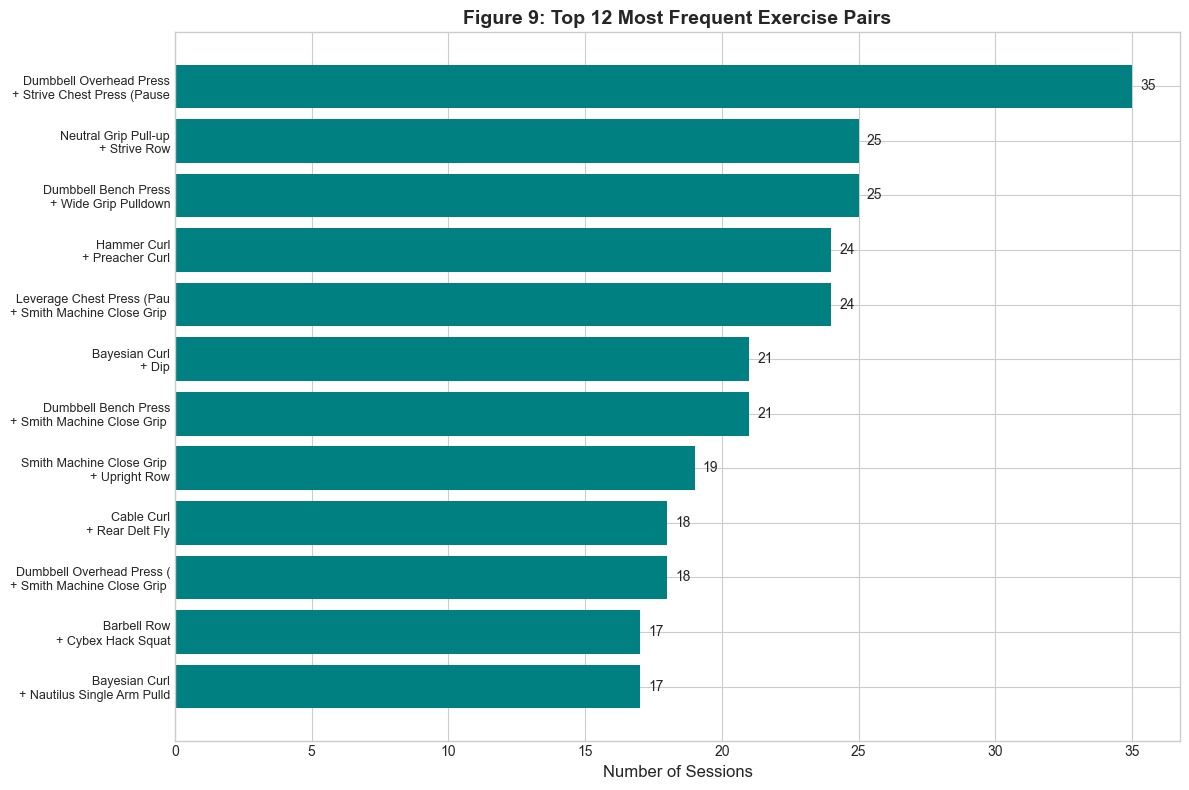

In [16]:
# Figure 9: Top Exercise Pairs
pair_counts_all = Counter()
for trans in transactions:
    for pair in combinations(sorted(set(trans)), 2):
        pair_counts_all[pair] += 1

fig, ax = plt.subplots(figsize=(12, 8))
top_pairs = pair_counts_all.most_common(12)
pair_labels = [f"{p[0][0][:25]}\n+ {p[0][1][:25]}" for p in top_pairs]
pair_values = [p[1] for p in top_pairs]

bars = ax.barh(range(len(top_pairs)), pair_values, color='teal')
ax.set_yticks(range(len(top_pairs)))
ax.set_yticklabels(pair_labels, fontsize=9)
ax.set_xlabel('Number of Sessions', fontsize=12)
ax.set_title('Figure 9: Top 12 Most Frequent Exercise Pairs', fontsize=14, fontweight='bold')
ax.invert_yaxis()

for bar, val in zip(bars, pair_values):
    ax.text(val + 0.3, bar.get_y() + bar.get_height()/2, str(val), va='center', fontsize=10)

plt.tight_layout()
plt.savefig('fig09_top_exercise_pairs.png', dpi=150)
plt.show()

## 6. Findings and Interpretation

### 6.1 Summary of Results

| Metric | Value |
|--------|-------|
| Total transactions (sessions) | 419 |
| Unique items (exercises) | 309 |
| Frequent items (support ≥ 5%) | 43 |
| Association rules generated | 10 |
| Average rule confidence | 0.699 (69.9%) |
| Average rule lift | 6.84 |
| Maximum rule lift | 8.73 |

### 6.2 Key Findings

---

#### Finding 1: Push-Push and Pull-Pull Exercise Pairing

**Evidence:**
| Rule | Support | Confidence | Lift |
|------|---------|------------|------|
| Dumbbell Overhead Press → Strive Chest Press (Paused) | 0.084 | 0.833 | 8.73 |
| Strive Chest Press (Paused) → Dumbbell Overhead Press | 0.084 | 0.875 | 8.73 |
| Neutral Grip Pull-up → Strive Row | 0.060 | 0.714 | 8.09 |
| Strive Row → Neutral Grip Pull-up | 0.060 | 0.676 | 8.09 |

**Interpretation:** The highest-lift rules reveal **same-movement-pattern pairing** rather than traditional push-pull antagonist training. When Dumbbell Overhead Press appears, there's an 83.3% chance Strive Chest Press also appears—8.73× more likely than random chance. Similarly, vertical pulling (pull-ups) and horizontal pulling (rows) co-occur with lift of 8.09.

**So What?** This indicates a training philosophy that prioritizes **movement-pattern grouping** where synergistic muscles are fatigued together within the same session, consistent with a Torso/Limbs split structure.

---

#### Finding 2: Paused Technique is Systematic

**Evidence:**
- 22.5% of all sets use paused technique
- Rule: Leverage Chest Press (Paused) → Smith Machine CG Bench Press (Paused) | Confidence: 88.9% | Lift: 7.60

**Interpretation:** Paused exercises cluster together within sessions. When one paused pressing movement appears, another paused pressing movement is highly likely (88.9% confidence).

**So What?** Paused reps are not random but a **deliberate training system** applied systematically—likely for strength development through increased time-under-tension at the sticking point.

---

#### Finding 3: Bicep Exercise Synergy

**Evidence:**
| Rule | Support | Confidence | Lift |
|------|---------|------------|------|
| Hammer Curl → Preacher Curl | 0.057 | 0.615 | 4.16 |

**Interpretation:** When Hammer Curls appear, Preacher Curls appear 61.5% of the time—4.16× more likely than chance.

**So What?** This indicates **bicep-focused sessions** where multiple curl variations target the muscle from different angles (brachialis via hammer curls, long head via preacher curls), consistent with bodybuilding-style isolation work.

---

#### Finding 4: Training Structure Evolution

**Evidence:**
- Early Period (Jan-Jun 2024): "Upper" (38), "Bro day" (26), "Legs" (25)
- Late Period (Jul 2025+): "Torso 1/2" (27), "Lower 1/2" (18), "Limbs 1/2" (15)

**Interpretation:** Workout naming evolved from generic labels to systematic A/B rotation patterns.

**So What?** Training matured from loosely-defined workouts to a **structured split with planned variations**, indicating increased programming sophistication over the 2-year period.

---

#### Finding 5: Consistent Workout Templates

**Evidence:**
| Exercise Pair | Sessions | % of Total |
|--------------|----------|------------|
| DB Overhead Press + Strive Chest Press (Paused) | 35 | 8.4% |
| Neutral Grip Pull-up + Strive Row | 25 | 6.0% |
| DB Bench Press + Wide Grip Pulldown | 25 | 6.0% |
| Hammer Curl + Preacher Curl | 24 | 5.7% |

**Interpretation:** Same exercise pairs appear in 5-8% of all sessions.

**So What?** These stable pairings indicate **programmed workout templates** rather than random daily exercise selection—a sign of structured training programming.

---

#### Finding 6: Unique "Limbs" Definition

**Evidence:**
Limbs/Lower workout exercises include:
- Preacher Curl (29.6%), Hammer Curl (19.0%) — ARM exercises
- Romanian Deadlift (26.1%), Cybex Hack Squat (25.4%) — LEG exercises

**Interpretation:** "Limbs" workouts combine arms AND legs in the same session.

**So What?** This is unconventional compared to traditional bodybuilding splits but explains the naming—"Limbs" literally means all extremities, not just legs.

### 6.3 Limitations

1. **Temporal Aggregation:** All 419 sessions are treated equally despite workout structure evolving significantly. Patterns from early 2024 may dilute patterns from late 2025.

2. **Exercise Order Not Captured:** Association rules show co-occurrence but not sequence—we don't know if pressing comes before or after pulling within sessions.

3. **Equipment Constraints:** Some pairings may reflect equipment availability at the gym rather than intentional programming choices.

4. **2-Itemset Limitation:** Without mlxtend's full implementation, only 2-itemset rules were generated. Larger patterns (3+ exercises together) were not captured.

### 6.4 Next Steps for M3

**Discovery Question 2 - Training Phase Segmentation (Clustering):**
- Apply K-Means clustering to session-level metrics (volume, intensity, exercise count)
- Use elbow method and silhouette score to determine optimal k
- Expected clusters: high-volume accumulation phases, intensity peaks, deload periods

**Discovery Question 3 - Performance Variation (Anomaly Detection):**
- Apply Isolation Forest to identify outlier sessions
- Characterize sessions with unusually high/low performance
- May reveal recovery issues, breakthrough sessions, or data entry errors

**Additional Analysis:**
- Segment data by training period (pre- vs. post-Torso/Limbs transition)
- Analyze associations within each workout type separately

In [17]:
# Export rules to CSV
if len(rules) > 0:
    rules_export = rules.copy()
    rules_export['antecedents'] = rules_export['antecedents'].apply(lambda x: ', '.join(sorted(x)))
    rules_export['consequents'] = rules_export['consequents'].apply(lambda x: ', '.join(sorted(x)))
    rules_export = rules_export.sort_values('lift', ascending=False)
    rules_export.to_csv('association_rules.csv', index=False)
    print("Rules exported to 'association_rules.csv'")

# Final summary
print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
print(f"\nDataset: {len(sessions_df)} sessions, {len(sets_df)} sets")
print(f"Date range: {sessions_df['date'].min().date()} to {sessions_df['date'].max().date()}")
print(f"Association rules: {len(rules)} rules discovered")
print(f"Key insight: Training follows movement-pattern grouping (push+push, pull+pull)")
print(f"\nFigures saved: fig01-fig09_*.png")

Rules exported to 'association_rules.csv'

ANALYSIS COMPLETE

Dataset: 419 sessions, 4831 sets
Date range: 2024-01-01 to 2026-01-29
Association rules: 10 rules discovered
Key insight: Training follows movement-pattern grouping (push+push, pull+pull)

Figures saved: fig01-fig09_*.png
